In [1]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score
# from tensorflow.keras.models import Model
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from tqdm import tqdm

## Setup Code

In [2]:
# load in padded dataset
chonky_padded_waveforms = pd.read_parquet('padded_waveforms.parquet')

In [3]:
# us to timesteps
us2timesteps = 100

In [4]:
# finalising the data arrays
padded_array = chonky_padded_waveforms['chonkers'].to_numpy()
x_data = np.stack(padded_array, axis=0)
# divide by max phd
max_phd = x_data.max()
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)
y_data = chonky_padded_waveforms['label'].to_numpy().reshape((-1,1))
print(y_data.shape)
input_length = x_data.shape[-1]
print(input_length)

0.0
1.0
(7782, 3028)
(7782, 1)
3028


In [5]:
# get training and testing sets
runID = chonky_padded_waveforms['runID']
eventID = chonky_padded_waveforms['eventID']
W_array = chonky_padded_waveforms['weights_no_gas'].to_numpy()
# X_train, X_test, \
# y_train, y_test, \
# W_train, W_test, \
# runID_train, runID_test, \
# eventID_train, eventID_test = \
# train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)
# print(X_train.shape)
# print(y_train.shape)
# print(X_train)
# print(y_train)
# X_train_reshaped = np.expand_dims(X_train, axis=-1)
# print(X_train_reshaped.shape)

# print(W_train.shape)

In [8]:
# function to make a cnn

def one_layer_cnn_test(X_train, y_train, W_train, X_test, y_test, W_test, filter_size, num_filters=10, train_iters=30):
    CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu', input_shape=(input_length, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.005),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3)
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.1, shuffle=True, sample_weight=W_train, verbose=0, callbacks=[callback])
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    y_predicted = CNN_model.predict(X_test)
    y_predicted_label = [np.argmax(i) for i in y_predicted]
    f1score = fbeta_score(y_test, y_predicted_label, beta=1, labels=[2], average=None)
    f2score = fbeta_score(y_test, y_predicted_label, beta=2, labels=[2], average=None)
    f3score = fbeta_score(y_test, y_predicted_label, beta=3, labels=[2], average=None)
    return test_loss, test_acc, test_weight_acc, f1score, f2score, f3score

def two_layer_cnn_test(X_train, y_train, W_train, X_test, y_test, W_test, filter_size, num_filters=10, train_iters=100):
    CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=6, kernel_size=538, activation='relu', input_shape=(input_length, 1)),
        keras.layers.Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0005),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10)
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.1, shuffle=True, sample_weight=W_train, verbose=0, callbacks=[callback])
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    y_predicted = CNN_model.predict(X_test)
    y_predicted_label = [np.argmax(i) for i in y_predicted]
    f1score = fbeta_score(y_test, y_predicted_label, beta=1, labels=[2], average=None)
    f2score = fbeta_score(y_test, y_predicted_label, beta=2, labels=[2], average=None)
    f3score = fbeta_score(y_test, y_predicted_label, beta=3, labels=[2], average=None)
    return test_loss, test_acc, test_weight_acc, f1score, f2score, f3score

# def two_layer_optimising_first_cnn_test(filter_size, num_filters=10, train_iters=25):
#     CNN_model = keras.Sequential([
#         # first layer from previous testing
#         keras.layers.Conv1D(filters=num_filters,kernel_size=filter_size,activation='relu', input_shape=(input_length, 1)),
#         # second layer for experimentation
#         keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu'),
#         keras.layers.Flatten(),
#         keras.layers.Dense(3, activation='softmax')
#     ])
#     callback = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                              patience=3)
#     CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
#                       loss='sparse_categorical_crossentropy',#'binary_crossentropy',
#                       metrics=['accuracy'],
#                       weighted_metrics=['accuracy'])
#     CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.2, shuffle=True, sample_weight=W_train, verbose=0, callbacks=[callback])
#     test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
#     return test_loss, test_acc, test_weight_acc

# main cross_val_loop

In [7]:
# filter_number = 10
# num_folds = 5

# conv_sizes_layer2 = np.around(np.logspace(-2, 1.3, 30) * us2timesteps)
# print(conv_sizes_layer2)
# conv_sizes_layer2 = np.delete(conv_sizes_layer2, [1, 3])
# print()
# print(conv_sizes_layer2)

# loss_arr = np.zeros((num_folds, len(conv_sizes_layer2)))
# acc_arr = np.zeros((num_folds, len(conv_sizes_layer2)))
# w_acc_arr = np.zeros((num_folds, len(conv_sizes_layer2)))
# f1_arr = np.zeros((num_folds, len(conv_sizes_layer2)))
# f2_arr = np.zeros((num_folds, len(conv_sizes_layer2)))
# f3_arr = np.zeros((num_folds, len(conv_sizes_layer2)))

# kfolds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

# print('Number of Filters - ' + str(filter_number))
# for j in tqdm(range(len(conv_sizes_layer2))):
#     print('Filter Size - ' + str(conv_sizes_layer2[j]))
#     fold_no = 1

#     for train, test in kfolds.split(x_data, y_data):
#         # print(type(x_data[train]))
#         loss, acc, w_acc, f1, f2, f3 = two_layer_cnn_test(x_data[train], y_data[train], W_array[train], 
#                                                           x_data[test], y_data[test], W_array[test], 
#                                                           filter_size=int(conv_sizes_layer2[j]), num_filters=int(filter_number))

#         loss_arr[fold_no-1, j] = loss
#         acc_arr[fold_no-1, j] = acc
#         w_acc_arr[fold_no-1, j] = w_acc
#         f1_arr[fold_no-1, j] = f1
#         f2_arr[fold_no-1, j] = f2
#         f3_arr[fold_no-1, j] = f3

#         # Increase fold number
#         fold_no = fold_no + 1

[1.000e+00 1.000e+00 2.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00
 6.000e+00 8.000e+00 1.100e+01 1.400e+01 1.800e+01 2.300e+01 3.000e+01
 3.900e+01 5.100e+01 6.600e+01 8.600e+01 1.120e+02 1.450e+02 1.890e+02
 2.450e+02 3.190e+02 4.140e+02 5.380e+02 7.000e+02 9.090e+02 1.181e+03
 1.535e+03 1.995e+03]

[1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 8.000e+00
 1.100e+01 1.400e+01 1.800e+01 2.300e+01 3.000e+01 3.900e+01 5.100e+01
 6.600e+01 8.600e+01 1.120e+02 1.450e+02 1.890e+02 2.450e+02 3.190e+02
 4.140e+02 5.380e+02 7.000e+02 9.090e+02 1.181e+03 1.535e+03 1.995e+03]
Number of Filters - 10


  0%|          | 0/28 [00:00<?, ?it/s]

Filter Size - 1.0


2024-04-17 21:14:58.502671: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-17 21:14:58.502697: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-17 21:14:58.502703: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-17 21:14:58.502979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 21:14:58.503337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-04-17 21:14:59.367384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 5s 22ms/step - loss: 0.0233 - accuracy: 0.6730 - weighted_accuracy: 0.7628 - val_loss: 0.0161 - val_accuracy: 0.5120 - val_weighted_accuracy: 0.5501
Epoch 2/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0162 - accuracy: 0.7810 - weighted_accuracy: 0.8633 - val_loss: 0.0070 - val_accuracy: 0.8283 - val_weighted_accuracy: 0.8395
Epoch 3/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0151 - accuracy: 0.8138 - weighted_accuracy: 0.8769 - val_loss: 0.0128 - val_accuracy: 0.6758 - val_weighted_accuracy: 0.7005
Epoch 4/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0144 - accuracy: 0.8247 - weighted_accuracy: 0.8808 - val_loss: 0.0116 - val_accuracy: 0.6790 - val_weighted_accuracy: 0.7001
Epoch 5/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0139 - accuracy: 0.8270 - weighted_accuracy: 0.8852 - val_loss: 0.0174 - val_accuracy: 0.5955 - val_weighted_accuracy:

  4%|▎         | 1/28 [04:43<2:07:21, 283.01s/it]

Filter Size - 2.0
Epoch 1/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0231 - accuracy: 0.6782 - weighted_accuracy: 0.7751 - val_loss: 0.0072 - val_accuracy: 0.8973 - val_weighted_accuracy: 0.8976
Epoch 2/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0164 - accuracy: 0.7931 - weighted_accuracy: 0.8629 - val_loss: 0.0102 - val_accuracy: 0.7448 - val_weighted_accuracy: 0.7430
Epoch 3/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0148 - accuracy: 0.8072 - weighted_accuracy: 0.8724 - val_loss: 0.0110 - val_accuracy: 0.7175 - val_weighted_accuracy: 0.7334
Epoch 4/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0145 - accuracy: 0.8179 - weighted_accuracy: 0.8764 - val_loss: 0.0099 - val_accuracy: 0.7592 - val_weighted_accuracy: 0.7686
Epoch 5/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0143 - accuracy: 0.8145 - weighted_accuracy: 0.8754 - val_loss: 0.0075 - val_accuracy: 0

  7%|▋         | 2/28 [10:35<2:20:16, 323.71s/it]

Filter Size - 3.0
Epoch 1/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0221 - accuracy: 0.6815 - weighted_accuracy: 0.7826 - val_loss: 0.0092 - val_accuracy: 0.7512 - val_weighted_accuracy: 0.7648
Epoch 2/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0161 - accuracy: 0.7963 - weighted_accuracy: 0.8685 - val_loss: 0.0090 - val_accuracy: 0.7624 - val_weighted_accuracy: 0.7726
Epoch 3/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0146 - accuracy: 0.8142 - weighted_accuracy: 0.8819 - val_loss: 0.0133 - val_accuracy: 0.6597 - val_weighted_accuracy: 0.6742
Epoch 4/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0140 - accuracy: 0.8197 - weighted_accuracy: 0.8806 - val_loss: 0.0071 - val_accuracy: 0.8154 - val_weighted_accuracy: 0.8208
Epoch 5/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0134 - accuracy: 0.8329 - weighted_accuracy: 0.8861 - val_loss: 0.0154 - val_accuracy: 0

 11%|█         | 3/28 [16:57<2:26:02, 350.49s/it]

Filter Size - 4.0
Epoch 1/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0222 - accuracy: 0.6723 - weighted_accuracy: 0.7745 - val_loss: 0.0112 - val_accuracy: 0.6693 - val_weighted_accuracy: 0.6980
Epoch 2/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0161 - accuracy: 0.7838 - weighted_accuracy: 0.8622 - val_loss: 0.0081 - val_accuracy: 0.7881 - val_weighted_accuracy: 0.7985
Epoch 3/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0154 - accuracy: 0.8027 - weighted_accuracy: 0.8668 - val_loss: 0.0096 - val_accuracy: 0.7400 - val_weighted_accuracy: 0.7544
Epoch 4/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0143 - accuracy: 0.8172 - weighted_accuracy: 0.8804 - val_loss: 0.0091 - val_accuracy: 0.7544 - val_weighted_accuracy: 0.7616
Epoch 5/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0134 - accuracy: 0.8274 - weighted_accuracy: 0.8829 - val_loss: 0.0084 - val_accuracy: 0

 14%|█▍        | 4/28 [22:59<2:22:00, 355.04s/it]

Filter Size - 5.0
Epoch 1/100
176/176 [==============================] - 5s 28ms/step - loss: 0.0230 - accuracy: 0.6778 - weighted_accuracy: 0.7824 - val_loss: 0.0114 - val_accuracy: 0.6870 - val_weighted_accuracy: 0.6913
Epoch 2/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0158 - accuracy: 0.8013 - weighted_accuracy: 0.8702 - val_loss: 0.0110 - val_accuracy: 0.7079 - val_weighted_accuracy: 0.7093
Epoch 3/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0150 - accuracy: 0.8033 - weighted_accuracy: 0.8721 - val_loss: 0.0116 - val_accuracy: 0.7047 - val_weighted_accuracy: 0.7170
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0150 - accuracy: 0.8151 - weighted_accuracy: 0.8764 - val_loss: 0.0103 - val_accuracy: 0.7448 - val_weighted_accuracy: 0.7567
Epoch 5/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0143 - accuracy: 0.8126 - weighted_accuracy: 0.8773 - val_loss: 0.0098 - val_accuracy: 0

 18%|█▊        | 5/28 [29:06<2:17:41, 359.18s/it]

Filter Size - 6.0
Epoch 1/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0219 - accuracy: 0.6805 - weighted_accuracy: 0.7756 - val_loss: 0.0082 - val_accuracy: 0.7849 - val_weighted_accuracy: 0.7894
Epoch 2/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0158 - accuracy: 0.7995 - weighted_accuracy: 0.8733 - val_loss: 0.0113 - val_accuracy: 0.6966 - val_weighted_accuracy: 0.7056
Epoch 3/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0145 - accuracy: 0.8133 - weighted_accuracy: 0.8765 - val_loss: 0.0060 - val_accuracy: 0.8636 - val_weighted_accuracy: 0.8574
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0143 - accuracy: 0.8177 - weighted_accuracy: 0.8783 - val_loss: 0.0093 - val_accuracy: 0.7737 - val_weighted_accuracy: 0.7657
Epoch 5/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0139 - accuracy: 0.8158 - weighted_accuracy: 0.8756 - val_loss: 0.0118 - val_accuracy: 0

 21%|██▏       | 6/28 [35:55<2:17:59, 376.33s/it]

Filter Size - 8.0
Epoch 1/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0221 - accuracy: 0.6789 - weighted_accuracy: 0.7879 - val_loss: 0.0086 - val_accuracy: 0.7978 - val_weighted_accuracy: 0.8079
Epoch 2/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0163 - accuracy: 0.7940 - weighted_accuracy: 0.8656 - val_loss: 0.0123 - val_accuracy: 0.6677 - val_weighted_accuracy: 0.6793
Epoch 3/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0152 - accuracy: 0.8069 - weighted_accuracy: 0.8729 - val_loss: 0.0089 - val_accuracy: 0.7769 - val_weighted_accuracy: 0.7863
Epoch 4/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0144 - accuracy: 0.8124 - weighted_accuracy: 0.8735 - val_loss: 0.0098 - val_accuracy: 0.7352 - val_weighted_accuracy: 0.7470
Epoch 5/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0139 - accuracy: 0.8197 - weighted_accuracy: 0.8785 - val_loss: 0.0154 - val_accuracy: 0

 25%|██▌       | 7/28 [42:47<2:15:43, 387.77s/it]

Filter Size - 11.0
Epoch 1/100
176/176 [==============================] - 4s 23ms/step - loss: 0.0225 - accuracy: 0.7026 - weighted_accuracy: 0.7868 - val_loss: 0.0150 - val_accuracy: 0.5185 - val_weighted_accuracy: 0.5316
Epoch 2/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0163 - accuracy: 0.7790 - weighted_accuracy: 0.8586 - val_loss: 0.0125 - val_accuracy: 0.6726 - val_weighted_accuracy: 0.6880
Epoch 3/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0154 - accuracy: 0.8001 - weighted_accuracy: 0.8666 - val_loss: 0.0063 - val_accuracy: 0.8700 - val_weighted_accuracy: 0.8679
Epoch 4/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0142 - accuracy: 0.8224 - weighted_accuracy: 0.8793 - val_loss: 0.0102 - val_accuracy: 0.7319 - val_weighted_accuracy: 0.7442
Epoch 5/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0144 - accuracy: 0.8172 - weighted_accuracy: 0.8778 - val_loss: 0.0096 - val_accuracy: 

 29%|██▊       | 8/28 [50:22<2:16:23, 409.17s/it]

Filter Size - 14.0
Epoch 1/100
176/176 [==============================] - 4s 23ms/step - loss: 0.0218 - accuracy: 0.6935 - weighted_accuracy: 0.7832 - val_loss: 0.0148 - val_accuracy: 0.5843 - val_weighted_accuracy: 0.5870
Epoch 2/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0166 - accuracy: 0.7785 - weighted_accuracy: 0.8522 - val_loss: 0.0089 - val_accuracy: 0.7785 - val_weighted_accuracy: 0.7908
Epoch 3/100
176/176 [==============================] - 3s 19ms/step - loss: 0.0156 - accuracy: 0.7953 - weighted_accuracy: 0.8702 - val_loss: 0.0106 - val_accuracy: 0.7143 - val_weighted_accuracy: 0.7204
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0148 - accuracy: 0.7999 - weighted_accuracy: 0.8701 - val_loss: 0.0080 - val_accuracy: 0.8026 - val_weighted_accuracy: 0.8137
Epoch 5/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0144 - accuracy: 0.8094 - weighted_accuracy: 0.8742 - val_loss: 0.0084 - val_accuracy: 

 32%|███▏      | 9/28 [56:44<2:06:58, 400.95s/it]

Filter Size - 18.0
Epoch 1/100
176/176 [==============================] - 5s 23ms/step - loss: 0.0227 - accuracy: 0.6928 - weighted_accuracy: 0.7718 - val_loss: 0.0124 - val_accuracy: 0.6565 - val_weighted_accuracy: 0.6755
Epoch 2/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0155 - accuracy: 0.8002 - weighted_accuracy: 0.8700 - val_loss: 0.0067 - val_accuracy: 0.8411 - val_weighted_accuracy: 0.8434
Epoch 3/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0152 - accuracy: 0.8101 - weighted_accuracy: 0.8750 - val_loss: 0.0101 - val_accuracy: 0.7448 - val_weighted_accuracy: 0.7583
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0140 - accuracy: 0.8270 - weighted_accuracy: 0.8834 - val_loss: 0.0091 - val_accuracy: 0.7737 - val_weighted_accuracy: 0.7887
Epoch 5/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0133 - accuracy: 0.8299 - weighted_accuracy: 0.8832 - val_loss: 0.0126 - val_accuracy: 

 36%|███▌      | 10/28 [1:01:48<1:51:14, 370.79s/it]

Filter Size - 23.0
Epoch 1/100
176/176 [==============================] - 5s 23ms/step - loss: 0.0217 - accuracy: 0.6862 - weighted_accuracy: 0.7902 - val_loss: 0.0124 - val_accuracy: 0.6132 - val_weighted_accuracy: 0.6317
Epoch 2/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0163 - accuracy: 0.7867 - weighted_accuracy: 0.8620 - val_loss: 0.0108 - val_accuracy: 0.7223 - val_weighted_accuracy: 0.7371
Epoch 3/100
176/176 [==============================] - 3s 20ms/step - loss: 0.0151 - accuracy: 0.8061 - weighted_accuracy: 0.8683 - val_loss: 0.0093 - val_accuracy: 0.7624 - val_weighted_accuracy: 0.7574
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0143 - accuracy: 0.8176 - weighted_accuracy: 0.8761 - val_loss: 0.0118 - val_accuracy: 0.6758 - val_weighted_accuracy: 0.6875
Epoch 5/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0135 - accuracy: 0.8177 - weighted_accuracy: 0.8812 - val_loss: 0.0139 - val_accuracy: 

 39%|███▉      | 11/28 [1:09:55<1:55:08, 406.40s/it]

Filter Size - 30.0
Epoch 1/100
176/176 [==============================] - 5s 24ms/step - loss: 0.0214 - accuracy: 0.7001 - weighted_accuracy: 0.7968 - val_loss: 0.0117 - val_accuracy: 0.6950 - val_weighted_accuracy: 0.6968
Epoch 2/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0165 - accuracy: 0.7890 - weighted_accuracy: 0.8580 - val_loss: 0.0171 - val_accuracy: 0.5329 - val_weighted_accuracy: 0.5418
Epoch 3/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0156 - accuracy: 0.8036 - weighted_accuracy: 0.8651 - val_loss: 0.0152 - val_accuracy: 0.6003 - val_weighted_accuracy: 0.6168
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0144 - accuracy: 0.8167 - weighted_accuracy: 0.8735 - val_loss: 0.0128 - val_accuracy: 0.6565 - val_weighted_accuracy: 0.6664
Epoch 5/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0140 - accuracy: 0.8185 - weighted_accuracy: 0.8725 - val_loss: 0.0172 - val_accuracy: 

 43%|████▎     | 12/28 [1:16:30<1:47:28, 403.03s/it]

Filter Size - 39.0
Epoch 1/100
176/176 [==============================] - 5s 24ms/step - loss: 0.0217 - accuracy: 0.6874 - weighted_accuracy: 0.7864 - val_loss: 0.0154 - val_accuracy: 0.5746 - val_weighted_accuracy: 0.5834
Epoch 2/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0177 - accuracy: 0.7819 - weighted_accuracy: 0.8567 - val_loss: 0.0125 - val_accuracy: 0.7175 - val_weighted_accuracy: 0.7218
Epoch 3/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0167 - accuracy: 0.7906 - weighted_accuracy: 0.8626 - val_loss: 0.0082 - val_accuracy: 0.8010 - val_weighted_accuracy: 0.8107
Epoch 4/100
176/176 [==============================] - 4s 20ms/step - loss: 0.0159 - accuracy: 0.8006 - weighted_accuracy: 0.8707 - val_loss: 0.0156 - val_accuracy: 0.5875 - val_weighted_accuracy: 0.5893
Epoch 5/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0154 - accuracy: 0.8070 - weighted_accuracy: 0.8725 - val_loss: 0.0130 - val_accuracy: 

 46%|████▋     | 13/28 [1:23:53<1:43:48, 415.23s/it]

Filter Size - 51.0
Epoch 1/100
176/176 [==============================] - 5s 25ms/step - loss: 0.0208 - accuracy: 0.7106 - weighted_accuracy: 0.8059 - val_loss: 0.0183 - val_accuracy: 0.5008 - val_weighted_accuracy: 0.5145
Epoch 2/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0160 - accuracy: 0.7954 - weighted_accuracy: 0.8644 - val_loss: 0.0107 - val_accuracy: 0.7512 - val_weighted_accuracy: 0.7404
Epoch 3/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0147 - accuracy: 0.8145 - weighted_accuracy: 0.8712 - val_loss: 0.0057 - val_accuracy: 0.8700 - val_weighted_accuracy: 0.8650
Epoch 4/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0136 - accuracy: 0.8297 - weighted_accuracy: 0.8775 - val_loss: 0.0146 - val_accuracy: 0.6372 - val_weighted_accuracy: 0.6447
Epoch 5/100
176/176 [==============================] - 4s 21ms/step - loss: 0.0132 - accuracy: 0.8292 - weighted_accuracy: 0.8794 - val_loss: 0.0102 - val_accuracy: 

 50%|█████     | 14/28 [1:30:07<1:33:56, 402.57s/it]

Filter Size - 66.0
Epoch 1/100
176/176 [==============================] - 5s 26ms/step - loss: 0.0226 - accuracy: 0.6739 - weighted_accuracy: 0.7804 - val_loss: 0.0131 - val_accuracy: 0.6244 - val_weighted_accuracy: 0.6443
Epoch 2/100
176/176 [==============================] - 4s 23ms/step - loss: 0.0174 - accuracy: 0.7681 - weighted_accuracy: 0.8451 - val_loss: 0.0135 - val_accuracy: 0.5907 - val_weighted_accuracy: 0.6073
Epoch 3/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0160 - accuracy: 0.7936 - weighted_accuracy: 0.8685 - val_loss: 0.0130 - val_accuracy: 0.6661 - val_weighted_accuracy: 0.6914
Epoch 4/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0148 - accuracy: 0.8151 - weighted_accuracy: 0.8747 - val_loss: 0.0117 - val_accuracy: 0.6998 - val_weighted_accuracy: 0.7113
Epoch 5/100
176/176 [==============================] - 4s 22ms/step - loss: 0.0139 - accuracy: 0.8270 - weighted_accuracy: 0.8794 - val_loss: 0.0102 - val_accuracy: 

 54%|█████▎    | 15/28 [1:36:53<1:27:27, 403.68s/it]

Filter Size - 86.0
Epoch 1/100
176/176 [==============================] - 5s 27ms/step - loss: 0.0213 - accuracy: 0.7071 - weighted_accuracy: 0.7889 - val_loss: 0.0066 - val_accuracy: 0.8411 - val_weighted_accuracy: 0.8428
Epoch 2/100
176/176 [==============================] - 4s 24ms/step - loss: 0.0163 - accuracy: 0.8036 - weighted_accuracy: 0.8675 - val_loss: 0.0144 - val_accuracy: 0.6100 - val_weighted_accuracy: 0.6080
Epoch 3/100
176/176 [==============================] - 4s 24ms/step - loss: 0.0145 - accuracy: 0.8194 - weighted_accuracy: 0.8804 - val_loss: 0.0124 - val_accuracy: 0.6934 - val_weighted_accuracy: 0.7081
Epoch 4/100
176/176 [==============================] - 4s 23ms/step - loss: 0.0138 - accuracy: 0.8224 - weighted_accuracy: 0.8827 - val_loss: 0.0061 - val_accuracy: 0.8555 - val_weighted_accuracy: 0.8561
Epoch 5/100
176/176 [==============================] - 4s 23ms/step - loss: 0.0131 - accuracy: 0.8386 - weighted_accuracy: 0.8880 - val_loss: 0.0126 - val_accuracy: 

 57%|█████▋    | 16/28 [1:43:47<1:21:20, 406.67s/it]

Filter Size - 112.0
Epoch 1/100
176/176 [==============================] - 6s 30ms/step - loss: 0.0221 - accuracy: 0.6796 - weighted_accuracy: 0.7867 - val_loss: 0.0146 - val_accuracy: 0.5811 - val_weighted_accuracy: 0.5910
Epoch 2/100
176/176 [==============================] - 5s 26ms/step - loss: 0.0168 - accuracy: 0.7908 - weighted_accuracy: 0.8617 - val_loss: 0.0058 - val_accuracy: 0.8652 - val_weighted_accuracy: 0.8647
Epoch 3/100
176/176 [==============================] - 4s 26ms/step - loss: 0.0150 - accuracy: 0.8120 - weighted_accuracy: 0.8724 - val_loss: 0.0062 - val_accuracy: 0.8571 - val_weighted_accuracy: 0.8566
Epoch 4/100
176/176 [==============================] - 4s 26ms/step - loss: 0.0147 - accuracy: 0.8149 - weighted_accuracy: 0.8683 - val_loss: 0.0091 - val_accuracy: 0.7801 - val_weighted_accuracy: 0.7825
Epoch 5/100
176/176 [==============================] - 4s 25ms/step - loss: 0.0135 - accuracy: 0.8302 - weighted_accuracy: 0.8869 - val_loss: 0.0077 - val_accuracy:

 61%|██████    | 17/28 [1:53:25<1:24:00, 458.24s/it]

Filter Size - 145.0
Epoch 1/100
176/176 [==============================] - 7s 34ms/step - loss: 0.0221 - accuracy: 0.6885 - weighted_accuracy: 0.7829 - val_loss: 0.0105 - val_accuracy: 0.7255 - val_weighted_accuracy: 0.7351
Epoch 2/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0173 - accuracy: 0.7667 - weighted_accuracy: 0.8461 - val_loss: 0.0114 - val_accuracy: 0.6934 - val_weighted_accuracy: 0.6902
Epoch 3/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0152 - accuracy: 0.8113 - weighted_accuracy: 0.8684 - val_loss: 0.0115 - val_accuracy: 0.7063 - val_weighted_accuracy: 0.7180
Epoch 4/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0141 - accuracy: 0.8236 - weighted_accuracy: 0.8753 - val_loss: 0.0143 - val_accuracy: 0.6292 - val_weighted_accuracy: 0.6619
Epoch 5/100
176/176 [==============================] - 5s 30ms/step - loss: 0.0136 - accuracy: 0.8279 - weighted_accuracy: 0.8774 - val_loss: 0.0149 - val_accuracy:

 64%|██████▍   | 18/28 [2:02:14<1:19:56, 479.65s/it]

Filter Size - 189.0
Epoch 1/100
176/176 [==============================] - 8s 39ms/step - loss: 0.0221 - accuracy: 0.7062 - weighted_accuracy: 0.8018 - val_loss: 0.0138 - val_accuracy: 0.7175 - val_weighted_accuracy: 0.7203
Epoch 2/100
176/176 [==============================] - 6s 34ms/step - loss: 0.0163 - accuracy: 0.7958 - weighted_accuracy: 0.8595 - val_loss: 0.0148 - val_accuracy: 0.6742 - val_weighted_accuracy: 0.6826
Epoch 3/100
176/176 [==============================] - 6s 33ms/step - loss: 0.0148 - accuracy: 0.8151 - weighted_accuracy: 0.8747 - val_loss: 0.0086 - val_accuracy: 0.7801 - val_weighted_accuracy: 0.7949
Epoch 4/100
176/176 [==============================] - 6s 33ms/step - loss: 0.0152 - accuracy: 0.8142 - weighted_accuracy: 0.8713 - val_loss: 0.0089 - val_accuracy: 0.7737 - val_weighted_accuracy: 0.7865
Epoch 5/100
176/176 [==============================] - 6s 34ms/step - loss: 0.0138 - accuracy: 0.8242 - weighted_accuracy: 0.8791 - val_loss: 0.0161 - val_accuracy:

 68%|██████▊   | 19/28 [2:14:45<1:24:08, 560.96s/it]

Filter Size - 245.0
Epoch 1/100
176/176 [==============================] - 8s 42ms/step - loss: 0.0213 - accuracy: 0.7014 - weighted_accuracy: 0.7987 - val_loss: 0.0069 - val_accuracy: 0.8732 - val_weighted_accuracy: 0.8706
Epoch 2/100
176/176 [==============================] - 7s 37ms/step - loss: 0.0150 - accuracy: 0.8104 - weighted_accuracy: 0.8727 - val_loss: 0.0079 - val_accuracy: 0.8026 - val_weighted_accuracy: 0.8082
Epoch 3/100
176/176 [==============================] - 6s 37ms/step - loss: 0.0145 - accuracy: 0.8163 - weighted_accuracy: 0.8729 - val_loss: 0.0173 - val_accuracy: 0.5714 - val_weighted_accuracy: 0.5987
Epoch 4/100
176/176 [==============================] - 7s 37ms/step - loss: 0.0136 - accuracy: 0.8252 - weighted_accuracy: 0.8811 - val_loss: 0.0108 - val_accuracy: 0.7528 - val_weighted_accuracy: 0.7452
Epoch 5/100
176/176 [==============================] - 6s 37ms/step - loss: 0.0134 - accuracy: 0.8251 - weighted_accuracy: 0.8749 - val_loss: 0.0112 - val_accuracy:

 71%|███████▏  | 20/28 [2:25:56<1:19:13, 594.25s/it]

Filter Size - 319.0
Epoch 1/100
176/176 [==============================] - 9s 49ms/step - loss: 0.0233 - accuracy: 0.6862 - weighted_accuracy: 0.7829 - val_loss: 0.0096 - val_accuracy: 0.7271 - val_weighted_accuracy: 0.7467
Epoch 2/100
176/176 [==============================] - 8s 44ms/step - loss: 0.0155 - accuracy: 0.8031 - weighted_accuracy: 0.8674 - val_loss: 0.0112 - val_accuracy: 0.7223 - val_weighted_accuracy: 0.7279
Epoch 3/100
176/176 [==============================] - 8s 44ms/step - loss: 0.0143 - accuracy: 0.8190 - weighted_accuracy: 0.8723 - val_loss: 0.0159 - val_accuracy: 0.6421 - val_weighted_accuracy: 0.6423
Epoch 4/100
176/176 [==============================] - 8s 44ms/step - loss: 0.0144 - accuracy: 0.8188 - weighted_accuracy: 0.8769 - val_loss: 0.0078 - val_accuracy: 0.7913 - val_weighted_accuracy: 0.7830
Epoch 5/100
176/176 [==============================] - 8s 44ms/step - loss: 0.0133 - accuracy: 0.8308 - weighted_accuracy: 0.8821 - val_loss: 0.0086 - val_accuracy:

 75%|███████▌  | 21/28 [2:39:22<1:16:44, 657.75s/it]

Filter Size - 414.0
Epoch 1/100
176/176 [==============================] - 11s 56ms/step - loss: 0.0214 - accuracy: 0.7139 - weighted_accuracy: 0.7911 - val_loss: 0.0091 - val_accuracy: 0.8026 - val_weighted_accuracy: 0.8090
Epoch 2/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0160 - accuracy: 0.8011 - weighted_accuracy: 0.8589 - val_loss: 0.0178 - val_accuracy: 0.5634 - val_weighted_accuracy: 0.5669
Epoch 3/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0134 - accuracy: 0.8192 - weighted_accuracy: 0.8794 - val_loss: 0.0056 - val_accuracy: 0.8764 - val_weighted_accuracy: 0.8757
Epoch 4/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0134 - accuracy: 0.8277 - weighted_accuracy: 0.8791 - val_loss: 0.0135 - val_accuracy: 0.6726 - val_weighted_accuracy: 0.6732
Epoch 5/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0128 - accuracy: 0.8288 - weighted_accuracy: 0.8816 - val_loss: 0.0121 - val_accuracy

 79%|███████▊  | 22/28 [2:54:17<1:12:53, 728.97s/it]

Filter Size - 538.0
Epoch 1/100
176/176 [==============================] - 12s 64ms/step - loss: 0.0226 - accuracy: 0.7121 - weighted_accuracy: 0.8000 - val_loss: 0.0142 - val_accuracy: 0.6180 - val_weighted_accuracy: 0.6278
Epoch 2/100
176/176 [==============================] - 11s 60ms/step - loss: 0.0170 - accuracy: 0.7847 - weighted_accuracy: 0.8557 - val_loss: 0.0115 - val_accuracy: 0.7207 - val_weighted_accuracy: 0.7221
Epoch 3/100
176/176 [==============================] - 10s 60ms/step - loss: 0.0152 - accuracy: 0.8061 - weighted_accuracy: 0.8611 - val_loss: 0.0132 - val_accuracy: 0.6629 - val_weighted_accuracy: 0.6699
Epoch 4/100
176/176 [==============================] - 10s 60ms/step - loss: 0.0143 - accuracy: 0.8154 - weighted_accuracy: 0.8748 - val_loss: 0.0069 - val_accuracy: 0.8347 - val_weighted_accuracy: 0.8389
Epoch 5/100
176/176 [==============================] - 10s 60ms/step - loss: 0.0136 - accuracy: 0.8252 - weighted_accuracy: 0.8787 - val_loss: 0.0078 - val_accu

 82%|████████▏ | 23/28 [3:11:47<1:08:46, 825.22s/it]

Filter Size - 700.0
Epoch 1/100
176/176 [==============================] - 14s 73ms/step - loss: 0.0208 - accuracy: 0.7126 - weighted_accuracy: 0.8013 - val_loss: 0.0151 - val_accuracy: 0.5907 - val_weighted_accuracy: 0.5796
Epoch 2/100
176/176 [==============================] - 11s 64ms/step - loss: 0.0159 - accuracy: 0.8097 - weighted_accuracy: 0.8691 - val_loss: 0.0143 - val_accuracy: 0.6372 - val_weighted_accuracy: 0.6627
Epoch 3/100
176/176 [==============================] - 11s 64ms/step - loss: 0.0141 - accuracy: 0.8243 - weighted_accuracy: 0.8813 - val_loss: 0.0120 - val_accuracy: 0.6709 - val_weighted_accuracy: 0.6809
Epoch 4/100
176/176 [==============================] - 11s 64ms/step - loss: 0.0137 - accuracy: 0.8260 - weighted_accuracy: 0.8793 - val_loss: 0.0069 - val_accuracy: 0.8459 - val_weighted_accuracy: 0.8457
Epoch 5/100
176/176 [==============================] - 11s 64ms/step - loss: 0.0129 - accuracy: 0.8338 - weighted_accuracy: 0.8858 - val_loss: 0.0092 - val_accu

 86%|████████▌ | 24/28 [3:28:17<58:18, 874.51s/it]  

Filter Size - 909.0
Epoch 1/100
176/176 [==============================] - 16s 85ms/step - loss: 0.0213 - accuracy: 0.7230 - weighted_accuracy: 0.8025 - val_loss: 0.0117 - val_accuracy: 0.7047 - val_weighted_accuracy: 0.7251
Epoch 2/100
176/176 [==============================] - 14s 80ms/step - loss: 0.0161 - accuracy: 0.7938 - weighted_accuracy: 0.8542 - val_loss: 0.0158 - val_accuracy: 0.6132 - val_weighted_accuracy: 0.6177
Epoch 3/100
176/176 [==============================] - 14s 79ms/step - loss: 0.0136 - accuracy: 0.8268 - weighted_accuracy: 0.8803 - val_loss: 0.0069 - val_accuracy: 0.8266 - val_weighted_accuracy: 0.8330
Epoch 4/100
176/176 [==============================] - 14s 79ms/step - loss: 0.0130 - accuracy: 0.8318 - weighted_accuracy: 0.8836 - val_loss: 0.0062 - val_accuracy: 0.8459 - val_weighted_accuracy: 0.8538
Epoch 5/100
176/176 [==============================] - 14s 79ms/step - loss: 0.0133 - accuracy: 0.8281 - weighted_accuracy: 0.8798 - val_loss: 0.0171 - val_accu

 89%|████████▉ | 25/28 [3:46:12<46:44, 934.70s/it]

Filter Size - 1181.0
Epoch 1/100
176/176 [==============================] - 17s 90ms/step - loss: 0.0215 - accuracy: 0.7278 - weighted_accuracy: 0.7835 - val_loss: 0.0101 - val_accuracy: 0.7464 - val_weighted_accuracy: 0.7571
Epoch 2/100
176/176 [==============================] - 15s 86ms/step - loss: 0.0137 - accuracy: 0.8201 - weighted_accuracy: 0.8737 - val_loss: 0.0102 - val_accuracy: 0.7319 - val_weighted_accuracy: 0.7469
Epoch 3/100
176/176 [==============================] - 15s 85ms/step - loss: 0.0127 - accuracy: 0.8317 - weighted_accuracy: 0.8867 - val_loss: 0.0087 - val_accuracy: 0.7689 - val_weighted_accuracy: 0.7717
Epoch 4/100
176/176 [==============================] - 15s 85ms/step - loss: 0.0124 - accuracy: 0.8370 - weighted_accuracy: 0.8871 - val_loss: 0.0122 - val_accuracy: 0.6597 - val_weighted_accuracy: 0.6850
Epoch 5/100
176/176 [==============================] - 15s 85ms/step - loss: 0.0125 - accuracy: 0.8243 - weighted_accuracy: 0.8761 - val_loss: 0.0200 - val_acc

 93%|█████████▎| 26/28 [4:12:08<37:22, 1121.07s/it]

Filter Size - 1535.0
Epoch 1/100
176/176 [==============================] - 18s 99ms/step - loss: 0.0199 - accuracy: 0.7321 - weighted_accuracy: 0.8114 - val_loss: 0.0066 - val_accuracy: 0.8459 - val_weighted_accuracy: 0.8569
Epoch 2/100
176/176 [==============================] - 17s 94ms/step - loss: 0.0149 - accuracy: 0.8156 - weighted_accuracy: 0.8729 - val_loss: 0.0064 - val_accuracy: 0.8379 - val_weighted_accuracy: 0.8423
Epoch 3/100
176/176 [==============================] - 16s 93ms/step - loss: 0.0132 - accuracy: 0.8302 - weighted_accuracy: 0.8853 - val_loss: 0.0124 - val_accuracy: 0.6854 - val_weighted_accuracy: 0.7054
Epoch 4/100
176/176 [==============================] - 16s 94ms/step - loss: 0.0128 - accuracy: 0.8333 - weighted_accuracy: 0.8855 - val_loss: 0.0055 - val_accuracy: 0.8668 - val_weighted_accuracy: 0.8717
Epoch 5/100
176/176 [==============================] - 16s 94ms/step - loss: 0.0128 - accuracy: 0.8315 - weighted_accuracy: 0.8861 - val_loss: 0.0129 - val_acc

 96%|█████████▋| 27/28 [4:41:03<21:45, 1305.50s/it]

Filter Size - 1995.0
Epoch 1/100
176/176 [==============================] - 19s 106ms/step - loss: 0.0218 - accuracy: 0.7253 - weighted_accuracy: 0.7862 - val_loss: 0.0150 - val_accuracy: 0.5875 - val_weighted_accuracy: 0.5826
Epoch 2/100
176/176 [==============================] - 18s 100ms/step - loss: 0.0159 - accuracy: 0.8010 - weighted_accuracy: 0.8693 - val_loss: 0.0163 - val_accuracy: 0.6116 - val_weighted_accuracy: 0.6106
Epoch 3/100
176/176 [==============================] - 18s 100ms/step - loss: 0.0143 - accuracy: 0.8142 - weighted_accuracy: 0.8775 - val_loss: 0.0177 - val_accuracy: 0.5955 - val_weighted_accuracy: 0.6004
Epoch 4/100
176/176 [==============================] - 18s 100ms/step - loss: 0.0140 - accuracy: 0.8169 - weighted_accuracy: 0.8683 - val_loss: 0.0123 - val_accuracy: 0.7095 - val_weighted_accuracy: 0.7275
Epoch 5/100
176/176 [==============================] - 17s 99ms/step - loss: 0.0126 - accuracy: 0.8358 - weighted_accuracy: 0.8860 - val_loss: 0.0092 - val

100%|██████████| 28/28 [5:14:22<00:00, 673.68s/it] 


In [8]:
# save metric arrays

# np.save('loss_10filt_sec', loss_arr)
# np.save('acc_10filt_sec', acc_arr)
# np.save('w_acc_10filt_sec', w_acc_arr)
# np.save('f1_10filt_sec', f1_arr)
# np.save('f2_10filt_sec', f2_arr)
# np.save('f3_10filt_sec', f3_arr)

[0.78438612 0.79929665 0.81560224 0.80566884 0.82244301 0.80637678
 0.83193902 0.8215054  0.83591687 0.8172081  0.7808043  0.80495493
 0.83645207 0.8099055  0.83615484 0.83183275 0.82565818 0.81698462
 0.80938402 0.83063916 0.82877871 0.80254752 0.8215575  0.79976835
 0.78815184 0.80018789 0.8093191  0.82281096]


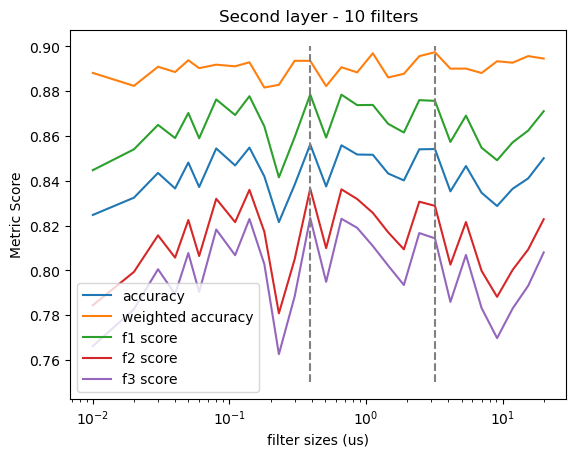

In [17]:
# print(np.mean(f2_arr, axis=0))
# # plt.figure()
# # plt.loglog(conv_sizes_layer1 / us2timesteps, np.mean(f3_arr, axis=0))#, yerr=np.std(f2_arr, axis=0))
# plt.figure()
# plt.semilogx(conv_sizes_layer2 / us2timesteps, np.mean(acc_arr, axis=0), label='accuracy')
# plt.semilogx(conv_sizes_layer2 / us2timesteps, np.mean(w_acc_arr, axis=0), label='weighted accuracy')
# plt.semilogx(conv_sizes_layer2 / us2timesteps, np.mean(f1_arr, axis=0), label='f1 score')
# plt.semilogx(conv_sizes_layer2 / us2timesteps, np.mean(f2_arr, axis=0), label='f2 score')
# plt.semilogx(conv_sizes_layer2 / us2timesteps, np.mean(f3_arr, axis=0), label='f3 score')
# plt.plot(np.zeros(50)+0.39, np.linspace(0.75,0.9), linestyle='dashed', color='grey')
# plt.plot(np.zeros(50)+3.19, np.linspace(0.75,0.9), linestyle='dashed', color='grey')
# # plt.plot(np.logspace(-2, 1.3), np.zeros(50)+0.78, linestyle='dashed', color='grey')
# plt.xlabel('filter sizes (us)')
# plt.ylabel('Metric Score')
# plt.title('Second layer - 10 filters')
# # plt.xscale='log'
# # plt.yscale='log'
# plt.legend()

In [16]:
# w_acc_array = np.array(w_acc_list_wider)


# print(np.where(np.mean(acc_arr, axis=0)==np.mean(acc_arr, axis=0).max()))
# print('acc filter size - ' + str(conv_sizes_layer2[np.where(np.mean(acc_arr, axis=0)==np.mean(acc_arr, axis=0).max())] / us2timesteps) + 'us')
# print('weighted acc filter size - ' + str(conv_sizes_layer2[np.where(np.mean(w_acc_arr, axis=0)==np.mean(w_acc_arr, axis=0).max())] / us2timesteps) + 'us')
# print('f1 filter size - ' + str(conv_sizes_layer2[np.where(np.mean(f1_arr, axis=0)==np.mean(f1_arr, axis=0).max())] / us2timesteps) + 'us')
# print('f2 filter size - ' + str(conv_sizes_layer2[np.where(np.mean(f2_arr, axis=0)==np.mean(f2_arr, axis=0).max())] / us2timesteps) + 'us')
# print('f3 filter size - ' + str(conv_sizes_layer2[np.where(np.mean(f3_arr, axis=0)==np.mean(f3_arr, axis=0).max())] / us2timesteps) + 'us')


(array([12]),)
acc filter size - [0.39]us
weighted acc filter size - [3.19]us
f1 filter size - [0.39]us
f2 filter size - [0.39]us
f3 filter size - [0.39]us


## Trying many filters for a 39 timestep second layer (538 timestep 6 filter first layer)

In [9]:
filter_number = np.linspace(2, 20, 10)
num_folds = 5

print(filter_number)

conv_sizes_fixed = 39

loss_arr = np.zeros((num_folds, len(filter_number)))
acc_arr = np.zeros((num_folds, len(filter_number)))
w_acc_arr = np.zeros((num_folds, len(filter_number)))
f1_arr = np.zeros((num_folds, len(filter_number)))
f2_arr = np.zeros((num_folds, len(filter_number)))
f3_arr = np.zeros((num_folds, len(filter_number)))

kfolds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

print('Filter Size - ' + str(conv_sizes_fixed))
for j in tqdm(range(len(filter_number))):
    print('Number of Filters - ' + str(filter_number[j]))
    fold_no = 1

    for train, test in kfolds.split(x_data, y_data):
        # print(type(x_data[train]))
        loss, acc, w_acc, f1, f2, f3 = two_layer_cnn_test(x_data[train], y_data[train], W_array[train], 
                                                          x_data[test], y_data[test], W_array[test], 
                                                          filter_size=int(conv_sizes_fixed), num_filters=int(filter_number[j]))

        loss_arr[fold_no-1, j] = loss
        acc_arr[fold_no-1, j] = acc
        w_acc_arr[fold_no-1, j] = w_acc
        f1_arr[fold_no-1, j] = f1
        f2_arr[fold_no-1, j] = f2
        f3_arr[fold_no-1, j] = f3

        # Increase fold number
        fold_no = fold_no + 1

[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
Filter Size - 39


  0%|          | 0/10 [00:00<?, ?it/s]

Number of Filters - 2.0
49/49 [==============================] - 0s 8ms/step


 10%|█         | 1/10 [06:38<59:44, 398.30s/it]

Number of Filters - 4.0
49/49 [==============================] - 0s 8ms/step


 20%|██        | 2/10 [11:11<43:18, 324.76s/it]

Number of Filters - 6.0
49/49 [==============================] - 0s 9ms/step


 30%|███       | 3/10 [16:40<38:08, 326.87s/it]

Number of Filters - 8.0
49/49 [==============================] - 0s 8ms/step


 40%|████      | 4/10 [22:11<32:49, 328.25s/it]

Number of Filters - 10.0
49/49 [==============================] - 1s 10ms/step


 50%|█████     | 5/10 [27:03<26:16, 315.21s/it]

Number of Filters - 12.0
49/49 [==============================] - 1s 10ms/step


 60%|██████    | 6/10 [34:27<23:55, 358.94s/it]

Number of Filters - 14.0
49/49 [==============================] - 1s 10ms/step


 70%|███████   | 7/10 [40:51<18:21, 367.09s/it]

Number of Filters - 16.0
49/49 [==============================] - 0s 9ms/step


 80%|████████  | 8/10 [47:52<12:49, 384.53s/it]

Number of Filters - 18.0
49/49 [==============================] - 1s 12ms/step


 90%|█████████ | 9/10 [54:55<06:36, 396.47s/it]

Number of Filters - 20.0
49/49 [==============================] - 1s 11ms/step


100%|██████████| 10/10 [1:00:54<00:00, 365.40s/it]


In [10]:
# save metric arrays

np.save('loss_39us_sec', loss_arr)
np.save('acc_39us_sec', acc_arr)
np.save('w_acc_39us_sec', w_acc_arr)
np.save('f1_39us_sec', f1_arr)
np.save('f2_39us_sec', f2_arr)
np.save('f3_39us_sec', f3_arr)

[0.8159154  0.78547088 0.78128054 0.82997484 0.77683363 0.83348258
 0.78730971 0.80623616 0.78997345 0.82818661]


Text(0.5, 1.0, 'Second layer - 0.39us Filter Size')

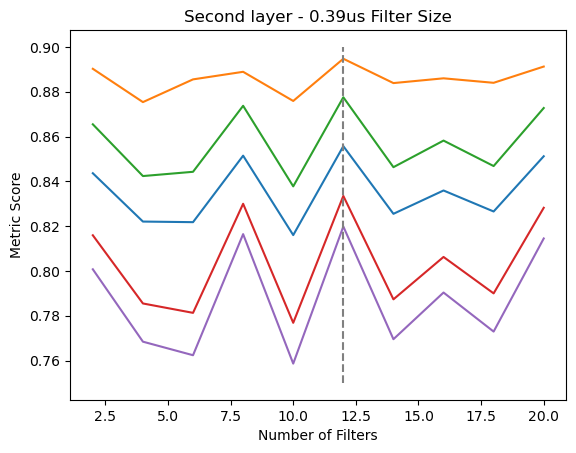

In [51]:
print(np.mean(f2_arr, axis=0))
# plt.figure()
# plt.loglog(conv_sizes_layer1 / us2timesteps, np.mean(f3_arr, axis=0))#, yerr=np.std(f2_arr, axis=0))
plt.figure()
plt.plot(filter_number, np.mean(acc_arr, axis=0), label='accuracy')
plt.plot(filter_number, np.mean(w_acc_arr, axis=0), label='weighted accuracy')
plt.plot(filter_number, np.mean(f1_arr, axis=0), label='f1 score')
plt.plot(filter_number, np.mean(f2_arr, axis=0), label='f2 score')
plt.plot(filter_number, np.mean(f3_arr, axis=0), label='f3 score')
# plt.plot(np.zeros(50)+6, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
plt.plot(np.zeros(50)+12, np.linspace(0.75,0.9), linestyle='dashed', color='grey')
# plt.plot(np.zeros(50)+9.09, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
# plt.plot(np.logspace(-2, 1.3), np.zeros(50)+0.78, linestyle='dashed', color='grey')
plt.xlabel('Number of Filters')
plt.ylabel('Metric Score')
plt.title('Second layer - 0.39us Filter Size')
# plt.xscale='log'
# plt.yscale='log'
# plt.legend()

In [14]:
print(np.where(np.mean(acc_arr, axis=0)==np.mean(acc_arr, axis=0).max()))
print('acc filter num - ' + str(filter_number[np.where(np.mean(acc_arr, axis=0)==np.mean(acc_arr, axis=0).max())]))
print('weighted acc filter num - ' + str(filter_number[np.where(np.mean(w_acc_arr, axis=0)==np.mean(w_acc_arr, axis=0).max())]))
print('f1 filter num - ' + str(filter_number[np.where(np.mean(f1_arr, axis=0)==np.mean(f1_arr, axis=0).max())]))
print('f2 filter num - ' + str(filter_number[np.where(np.mean(f2_arr, axis=0)==np.mean(f2_arr, axis=0).max())]))
print('f3 filter num - ' + str(filter_number[np.where(np.mean(f3_arr, axis=0)==np.mean(f3_arr, axis=0).max())]))

(array([5]),)
acc filter num - [12.]
weighted acc filter num - [12.]
f1 filter num - [12.]
f2 filter num - [12.]
f3 filter num - [12.]


# Going a bit higher with the filter numbers

In [27]:
filter_number_larger = np.linspace(23, 47, 9)
num_folds = 5

print(filter_number_larger)

# conv_sizes_layer1 = np.around(np.logspace(-2, 1.3, 30) * us2timesteps)
# print(conv_sizes_layer1)
# conv_sizes_layer1 = np.delete(conv_sizes_layer1, [1, 3])
# print()
# print(conv_sizes_layer1)

conv_sizes_fixed = 39

loss_arr_larger = np.zeros((num_folds, len(filter_number_larger)))
acc_arr_larger = np.zeros((num_folds, len(filter_number_larger)))
w_acc_arr_larger = np.zeros((num_folds, len(filter_number_larger)))
f1_arr_larger = np.zeros((num_folds, len(filter_number_larger)))
f2_arr_larger = np.zeros((num_folds, len(filter_number_larger)))
f3_arr_larger = np.zeros((num_folds, len(filter_number_larger)))

kfolds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

print('Filter Size - ' + str(conv_sizes_fixed))
for j in tqdm(range(len(filter_number_larger))):
    print('Number of Filters - ' + str(filter_number_larger[j]))
    fold_no = 1

    for train, test in kfolds.split(x_data, y_data):
        # print(type(x_data[train]))
        loss, acc, w_acc, f1, f2, f3 = two_layer_cnn_test(x_data[train], y_data[train], W_array[train], 
                                                          x_data[test], y_data[test], W_array[test], 
                                                          filter_size=int(conv_sizes_fixed), num_filters=int(filter_number_larger[j]))

        loss_arr_larger[fold_no-1, j] = loss
        acc_arr_larger[fold_no-1, j] = acc
        w_acc_arr_larger[fold_no-1, j] = w_acc
        f1_arr_larger[fold_no-1, j] = f1
        f2_arr_larger[fold_no-1, j] = f2
        f3_arr_larger[fold_no-1, j] = f3

        # Increase fold number
        fold_no = fold_no + 1

[23. 26. 29. 32. 35. 38. 41. 44. 47.]
Filter Size - 39


  0%|          | 0/9 [00:00<?, ?it/s]

Number of Filters - 23.0
49/49 [==============================] - 1s 10ms/step


 11%|█         | 1/9 [08:07<1:05:01, 487.68s/it]

Number of Filters - 26.0
49/49 [==============================] - 1s 13ms/step


 22%|██▏       | 2/9 [16:01<55:55, 479.33s/it]  

Number of Filters - 29.0
49/49 [==============================] - 1s 12ms/step


 33%|███▎      | 3/9 [23:42<47:07, 471.27s/it]

Number of Filters - 32.0
49/49 [==============================] - 1s 12ms/step


 44%|████▍     | 4/9 [32:33<41:14, 494.85s/it]

Number of Filters - 35.0
49/49 [==============================] - 1s 13ms/step


 56%|█████▌    | 5/9 [43:35<36:59, 554.83s/it]

Number of Filters - 38.0
49/49 [==============================] - 1s 13ms/step


 67%|██████▋   | 6/9 [54:54<29:52, 597.36s/it]

Number of Filters - 41.0
49/49 [==============================] - 1s 12ms/step


 78%|███████▊  | 7/9 [1:06:20<20:52, 626.04s/it]

Number of Filters - 44.0
49/49 [==============================] - 1s 9ms/step


 89%|████████▉ | 8/9 [1:17:24<10:38, 638.39s/it]

Number of Filters - 47.0
49/49 [==============================] - 1s 16ms/step


100%|██████████| 9/9 [1:32:15<00:00, 615.06s/it]


In [28]:
print(np.where(np.mean(acc_arr_larger, axis=0)==np.mean(acc_arr_larger, axis=0).max()))
print('acc filter num - ' + str(filter_number_larger[np.where(np.mean(acc_arr_larger, axis=0)==np.mean(acc_arr_larger, axis=0).max())]))
print('weighted acc filter num - ' + str(filter_number_larger[np.where(np.mean(w_acc_arr_larger, axis=0)==np.mean(w_acc_arr_larger, axis=0).max())]))
print('f1 filter num - ' + str(filter_number_larger[np.where(np.mean(f1_arr_larger, axis=0)==np.mean(f1_arr_larger, axis=0).max())]))
print('f2 filter num - ' + str(filter_number_larger[np.where(np.mean(f2_arr_larger, axis=0)==np.mean(f2_arr_larger, axis=0).max())]))
print('f3 filter num - ' + str(filter_number_larger[np.where(np.mean(f3_arr_larger, axis=0)==np.mean(f3_arr_larger, axis=0).max())]))

(array([5]),)
acc filter num - [38.]
weighted acc filter num - [41.]
f1 filter num - [38.]
f2 filter num - [38.]
f3 filter num - [38.]


[[0.76302274 0.79302058 0.85139479 0.79912253 0.75632015 0.8920478
  0.81892061 0.793601   0.82743547]
 [0.7780799  0.72878326 0.85233722 0.86021505 0.81137382 0.8074922
  0.84533306 0.72150832 0.78378096]
 [0.82726327 0.81526272 0.80342237 0.76261408 0.81743301 0.76083534
  0.74876433 0.8601594  0.83575581]
 [0.81002088 0.78437533 0.82803875 0.81010544 0.78429319 0.86105067
  0.7928041  0.83133909 0.81464483]
 [0.8523844  0.79620161 0.80971238 0.74902826 0.77406515 0.83316019
  0.76842436 0.85454169 0.74490439]]
[0.80615424 0.7835287  0.8289811  0.79621707 0.78869706 0.83091724
 0.79484929 0.8122299  0.80130429]


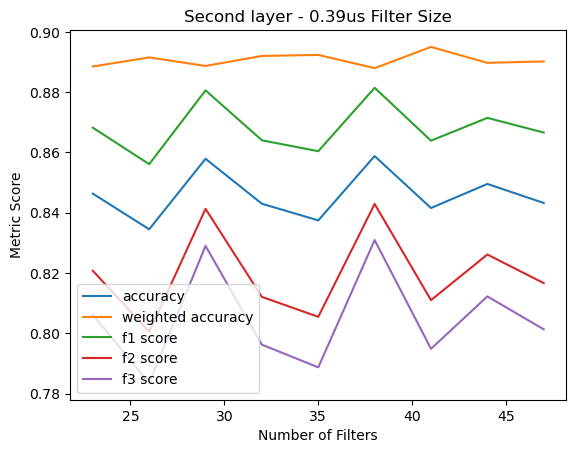

In [42]:
# print(np.mean(f3_arr_larger, axis=0))
print(f3_arr_larger[f3_arr_larger != 0].reshape(acc_arr_larger.shape))
f3_arr_larger = f3_arr_larger[f3_arr_larger != 0].reshape(acc_arr_larger.shape)
print(np.mean(f3_arr_larger, axis=0))

# plt.figure()
# plt.loglog(conv_sizes_layer1 / us2timesteps, np.mean(f3_arr, axis=0))#, yerr=np.std(f2_arr, axis=0))
plt.figure()
plt.plot(filter_number_larger, np.mean(acc_arr_larger, axis=0), label='accuracy')
plt.plot(filter_number_larger, np.mean(w_acc_arr_larger, axis=0), label='weighted accuracy')
plt.plot(filter_number_larger, np.mean(f1_arr_larger, axis=0), label='f1 score')
plt.plot(filter_number_larger, np.mean(f2_arr_larger, axis=0), label='f2 score')
plt.plot(filter_number_larger, np.mean(f3_arr_larger, axis=0), label='f3 score')
# plt.plot(np.zeros(50)+6, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
#plt.plot(np.zeros(50)+12, np.linspace(0.75,0.9), linestyle='dashed', color='grey')
# plt.plot(np.zeros(50)+9.09, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
# plt.plot(np.logspace(-2, 1.3), np.zeros(50)+0.78, linestyle='dashed', color='grey')
plt.xlabel('Number of Filters')
plt.ylabel('Metric Score')
plt.title('Second layer - 0.39us Filter Size')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

In [43]:
# save metric arrays

np.save('loss_39us_sec_larger', loss_arr_larger)
np.save('acc_39us_sec_larger', acc_arr_larger)
np.save('w_acc_39us_sec_larger', w_acc_arr_larger)
np.save('f1_39us_sec_larger', f1_arr_larger)
np.save('f2_39us_sec_larger', f2_arr_larger)
np.save('f3_39us_sec_larger', f3_arr_larger)

In [48]:
# combined plot

# loss_means_comb = np.concatenate((np.mean(loss_arr, axis=0), np.mean(loss_arr_larger, axis=0)))
filter_number_comb = np.concatenate((filter_number, filter_number_larger))
acc_means_comb = np.concatenate((np.mean(acc_arr, axis=0), np.mean(acc_arr_larger, axis=0)))
w_acc_means_comb = np.concatenate((np.mean(w_acc_arr, axis=0), np.mean(w_acc_arr_larger, axis=0)))
f1_means_comb = np.concatenate((np.mean(f1_arr, axis=0), np.mean(f1_arr_larger, axis=0)))
f2_means_comb = np.concatenate((np.mean(f2_arr, axis=0), np.mean(f2_arr_larger, axis=0)))
f3_means_comb = np.concatenate((np.mean(f3_arr, axis=0), np.mean(f3_arr_larger, axis=0)))

print(np.where(acc_means_comb==acc_means_comb.max()))
print('acc filter num - ' + str(filter_number_comb[np.where(acc_means_comb==acc_means_comb.max())]))
print('weighted acc filter num - ' + str(filter_number_comb[np.where(w_acc_means_comb==w_acc_means_comb.max())]))
print('f1 filter num - ' + str(filter_number_comb[np.where(f1_means_comb==f1_means_comb.max())]))
print('f2 filter num - ' + str(filter_number_comb[np.where(f2_means_comb==f2_means_comb.max())]))
print('f3 filter num - ' + str(filter_number_comb[np.where(f3_means_comb==f3_means_comb.max())]))

(array([15]),)
acc filter num - [38.]
weighted acc filter num - [41.]
f1 filter num - [38.]
f2 filter num - [38.]
f3 filter num - [38.]


Text(0.5, 1.0, 'Second layer - 0.39us Filter Size')

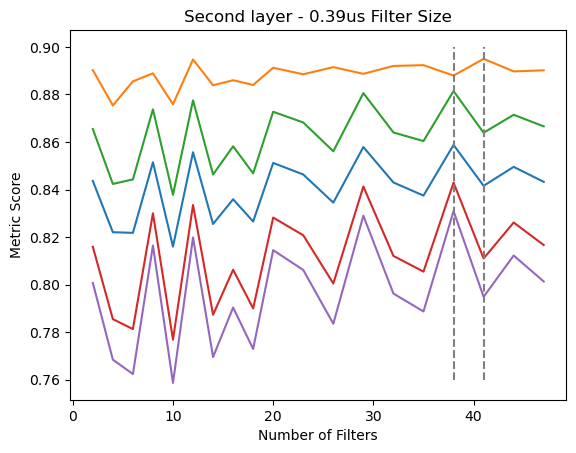

In [52]:
plt.figure()
plt.plot(filter_number_comb, acc_means_comb, label='accuracy')
plt.plot(filter_number_comb, w_acc_means_comb, label='weighted accuracy')
plt.plot(filter_number_comb, f1_means_comb, label='f1 score')
plt.plot(filter_number_comb, f2_means_comb, label='f2 score')
plt.plot(filter_number_comb, f3_means_comb, label='f3 score')
plt.plot(np.zeros(50)+38, np.linspace(0.76,0.9), linestyle='dashed', color='grey')
plt.plot(np.zeros(50)+41, np.linspace(0.76,0.9), linestyle='dashed', color='grey')
# plt.plot(np.zeros(50)+9.09, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
# plt.plot(np.logspace(-2, 1.3), np.zeros(50)+0.78, linestyle='dashed', color='grey')
plt.xlabel('Number of Filters')
plt.ylabel('Metric Score')
plt.title('Second layer - 0.39us Filter Size')
# plt.xscale='log'
# plt.yscale='log'
# plt.legend()

In [11]:
# # testing number of convolutions

# num_filters_big_range = np.around(np.logspace(0, 3, 25))[:21]
# num_filters_big_range = np.delete(num_filters_big_range, [1, 3])
# conv_size_big_range = 319

# loss_list_big_range = []
# acc_list_big_range = []
# w_acc_list_big_range = []

# print('Number of Filters - ' + str(num_filters_big_range))
# for j in tqdm(range(len(num_filters_big_range))):
#     loss, acc, w_acc = two_layer_cnn_test(filter_size=int(conv_size_big_range),
#                                           num_filters=int(num_filters_big_range[j])
#                                           )
#     loss_list_big_range.append(loss)
#     acc_list_big_range.append(acc)
#     w_acc_list_big_range.append(w_acc)

In [12]:
# plt.figure()
# plt.loglog(num_filters_big_range[:len(acc_list_big_range)], acc_list_big_range, label='accuracy')
# plt.loglog(num_filters_big_range[:len(w_acc_list_big_range)], w_acc_list_big_range, label='weighted accuracy')
# plt.xlabel('number of filters')
# plt.ylabel('accuracy score')
# plt.title('initial layer accuracies - 3.19us (319 t-steps)')
# # plt.xscale='log'
# # plt.yscale='log'
# plt.legend()